**SCRAPING: Impact ondernemingen**

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
from bs4 import BeautifulSoup
import re

**SOCIALE ZAKEN**

Op de website sociale zaken staan sociale firma's erkend door de gemeente. Run de onderstaande cells om deze bedrijven in één lijst te krijgen.

In [3]:
# Initialize the webdriver
driver = webdriver.Firefox()  # or use your preferred browser
wait = WebDriverWait(driver, 10)

# Open the page
driver.get("https://socialezaken.info/nl/gemeente")
time.sleep(3)  # allow page to load

In [4]:
results = []

# get all cards (by class "innah")
cards = wait.until(EC.presence_of_all_elements_located(
    (By.CSS_SELECTOR, "div.innah")
))

# Use indexes for stability
for i in range(len(cards)):

    # re-find cards on every loop
    cards = wait.until(EC.presence_of_all_elements_located(
        (By.CSS_SELECTOR, "div.innah")
    ))
    card = cards[i]

    # extract name inside h2
    try:
        h2 = card.find_element(By.TAG_NAME, "h2")
        name = h2.text.strip()
    except:
        name = ""
    
    # click card
    driver.execute_script("arguments[0].scrollIntoView(true);", card)
    time.sleep(0.5)
    card.click()

    # extract address on detail page
    try:
        sticky = wait.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR, "div.four.sticky")
        ))
        p = sticky.find_element(By.CSS_SELECTOR, "p.zero-bottom")
        address = p.text.strip()
        address = address.replace("\n", ", ")
        
    except:
        address = ""
    
    # extract category
    try:
        category_element = driver.find_element(By.CSS_SELECTOR, "ul.zero-horizontal.filter.clearfix li span")
        category = category_element.text.strip()
    except:
        category = ""

    # extract impact label
    try:
        impact_element = driver.find_element(By.CSS_SELECTOR, "ul.filter.clearfix:not(.zero-horizontal) li")
        impact_label = impact_element.text.strip()
    except:
        impact_label = ""

    # save result
    results.append({
        "Naam": name,
        "Adres": address,
        "Categorie": category,
        "Impact": impact_label
    })

    # go back to previous page
    driver.back()
    time.sleep(1)

# Convert to DataFrame
socialezaken = pd.DataFrame(results)
driver.quit()

In [70]:
socialezaken.shape

(100, 4)

**SOCIAL ENTERPRISE NL**

Social Enterprise NL is het landelijke netwerk voor sociale ondernemingen, ondernemingen die als primair doel hebben maatschappelijke meerwaarde (impact) te creëren.
Hoewel er een pagina is waar de leden op een rij staan, staan er hier geen adresgegevens bij. Daarom worden deze direct van de kaart gehaald door de source te inspecteren en te filteren op postcode format. Hierna wordt op Amsterdam gefilterd

In [6]:
driver = webdriver.Firefox()
driver.get("https://social-enterprise.nl/onze-leden/leden-kaart/")

# Let the page load
driver.implicitly_wait(5)

In [7]:
# Get page source
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

results = []

# All <span class="full-search-data">
for span in soup.find_all("span", class_="full-search-data"):
    text = span.get_text(strip=True)
    # Split address and name at the last hyphen
    if "-" in text:
        address, name = map(str.strip, text.rsplit("-", 1))
    else:
        address, name = "", text
    # Extract postal code (four digits at start of city line)
    postal_match = re.search(r"\b(\d{4})\b", address)
    if postal_match:
        postal = int(postal_match.group(1))
        if 1000 <= postal <= 1109:  # Amsterdam postal code range
            results.append({
                "Naam": name,
                "Adres": address.replace("\n", ", ")
            })

# Create DataFrame
socialenterprisenl = pd.DataFrame(results)
print(socialenterprisenl)

driver.quit()

                                Naam  \
0                            Droppie   
1                  Accent Schoonmaak   
2                           twinpacT   
3    Zwarte Vrouwen Voor Technologie   
4                   Ervaring spreekt   
..                               ...   
99                          Sumthing   
100                        Blue Road   
101                     BORO*ATELIER   
102              LemonAid & ChariTea   
103                      Talentcoach   

                                             Adres  
0    Van Limburg Stirumplein 1 , 1051 BD Amsterdam  
1            Karl Grogersingel , 1069 NX Amsterdam  
2                     Kabelweg , 1014 BB Amsterdam  
3              Grubbehoeve 222 , 1103 GT Amsterdam  
4            Haarlemmerweg 1084 , 1014BL Amsterdam  
..                                             ...  
99             Krugerplein 36A , 1091 LA Amsterdam  
100            herengracht 495 , 1017 BT Amsterdam  
101   Ferdinand Huyckstraat 26 , 1061 HW A

**BCORP**

De Bcorp data is niet te scrappen en deze is alleen verkrijgbaar als csv file van de volgende site: 
https://kb.bimpactassessment.net/en/support/solutions/articles/43000570530-using-sql-in-b-corp-impact-data-tutorial-
Deze dient gedownload te worden waarna de path (file locatie) aangepast moet worden in de volgende cell (In plaats van "Data/B-Corp.csv")
Omdat er geen adresgegevens in deze dataset staan wordt deze file gemerged met de oude Bcorp data (die de vorige keer gebruikt is) op basis van adres. 

In [45]:
Bcorp = pd.read_csv(r"C:\Users\engele016\OneDrive - Gemeente Amsterdam\Documenten\Github\Impact-data-scraper\B Corp Impact Data.csv")

C:\Users\engele016\AppData\Local\Temp\ipykernel_20524\1910107611.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  Bcorp = pd.read_csv(r"C:\Users\engele016\OneDrive - Gemeente Amsterdam\Documenten\Github\Impact-data-scraper\B Corp Impact Data.csv")


In [9]:
Bcorp = Bcorp[["company_name","date_first_certified", "date_certified", "current_status","website", "b_corp_profile", "sector", "city", "country", "other_countries_of_operation" ]]

In [10]:
filtered = Bcorp[
    (Bcorp["city"] == "Amsterdam") |
    (Bcorp["other_countries_of_operation"] == "The Netherlands")|
    (Bcorp["city"] == "AMSTERDAM")]

In [11]:
filtered = filtered.drop_duplicates(subset="company_name", keep="first")

In [12]:
filtered.shape

(202, 10)

Vul hier bij het path de directory van de oude bcorp data in.

In [46]:
bcorp_old = pd.read_excel(r"C:\Users\engele016\OneDrive - Gemeente Amsterdam\Documenten\Github\Impact-data-scraper\Bcorp_manual_adress.xlsx")

In [47]:
filtered = filtered.rename(columns={"company_name": "Naam"})

In [48]:
# filtered: has at least ["Naam", "current_status"] where current_status is "certified" or "de-certified"
# bcorp_old: has at least ["Naam", "Adres"]

def _norm_name(s: pd.Series) -> pd.Series:
    return (s.astype("string")
              .str.strip()
              .str.replace(r"\s+", " ", regex=True)
              .str.casefold())

# Copies + normalized join keys
f = filtered.copy()
b = bcorp_old.copy()

f["_key"] = _norm_name(f["Naam"])
b["_key"] = _norm_name(b["Naam"])

# If filtered has duplicates per company, keep one 
f = (f.dropna(subset=["_key"])
       .drop_duplicates(subset=["_key"], keep="last"))

# Full outer merge to keep companies from BOTH tables 
new_df = b.merge(
    f[["_key", "current_status"]],
    on="_key",
    how="outer"
)

# Build Naam: prefer bcorp_old name, otherwise fall back to filtered name ----
f_name_map = f.drop_duplicates("_key").set_index("_key")["Naam"]
new_df["Naam"] = new_df["Naam"].combine_first(
    new_df["_key"].map(f_name_map)
)


# Status fill for companies not in filtered yet 
# If you prefer unknown instead, change "certified" -> "unknown"
new_df["current_status"] = new_df["current_status"].fillna("certified")

# Flag companies that are NOT decertified 
new_df["not_decertified"] = new_df["current_status"].ne("de-certified")

# Count empty / None address rows (None, NaN, or blank/whitespace) 
addr = new_df["Adres"].astype("string")
empty_or_none_count = int(new_df["Adres"].isna().sum() + addr.str.strip().eq("").sum())

print("Empty/None address rows:", empty_or_none_count)

# Optional cleanup/order 
bcorp = new_df.drop(columns=["_key"])  # keep "Adres" if you want; otherwise drop it too
# new_df = new_df.drop(columns=["_key", "Adres"])

cols_first = ["Naam", "current_status", "not_decertified", "Adres"]
bcorp = bcorp[cols_first + [c for c in bcorp.columns if c not in cols_first]]


Empty/None address rows: 40


In [49]:
# drop all "current_status" == "de-certified" and keep only "certified" 
bcorp = bcorp[bcorp["current_status"] == "certified"]

In [50]:
bcorp.head()

,Naam,current_status,not_decertified,Adres,Adres onvolledig,Postcode,Stadsdeel,type organisatie 1
0,10DAYS,certified,True,"Cornelis Schuytstraat 18, 1071 JJ",Cornelis Schuytstraat 18,1071 JJ,Amsterdam Zuid,Bcorp
1,A Beautiful Story,certified,True,"Veemarkt 125, 1019 CD",Veemarkt 125,1019 CD,Amsterdam Centrum,Bcorp
2,A Beautiful Story B.V.,certified,True,NaN,NaN,NaN,NaN,NaN
3,A-dam Underwear B.V.,certified,True,"Danzigerbocht, 1013 AM",Danzigerbocht,1013 AM,Amsterdam Westpoort,Bcorp
4,Academica University of Applied Sciences,certified,True,"Weteringschans 28, 1017 SG",Weteringschans 28,1017 SG,Amsterdam Centrum,Bcorp


**STEWARD OWNERSHIP**

De steward ownership data is alleen als kaart zichtbaar. De webscraper zal elk locatiepunt op deze kaart openen en het adres en bedrijf opslaan waarna het filtered op alleen Amsterdam. Dit zal wat tijd kosten.

In [18]:
URL="https://wearestewards.nl/en/companies/"
LIST="div.mU4ghb-pbTTYe-n0tgWb-haAclf"
ROW="div.HzV7m-pbTTYe-ibnC6b.pbTTYe-ibnC6b-d6wfac"
MORE="div.HzV7m-pbTTYe-bN97Pc-ti6hGc-z5C9Gb-haAclf"
BACK="span.HzV7m-tJHJj-LgbsSe-Bz112c.qqvbed-a4fUwd-LgbsSe-Bz112c"

d=webdriver.Firefox(); w=WebDriverWait(d,20); d.get(URL); time.sleep(5)
R=[]; S=set()
PC = re.compile(r"\b\d{4}\s?[A-Z]{2}\b", re.I)

for fr in d.find_elements(By.CSS_SELECTOR,"iframe"):
    s=(fr.get_attribute("src") or "").lower()
    if "google" in s and "maps" in s: d.switch_to.frame(fr); break

w.until(EC.presence_of_element_located((By.CSS_SELECTOR, LIST)))

stall=0; last=0
while stall<5:
    ms=d.find_elements(By.CSS_SELECTOR, MORE)
    if ms and ms[0].is_displayed():
        d.execute_script("arguments[0].scrollIntoView({block:'center'});arguments[0].click();", ms[0]); time.sleep(.6)
    c=len(d.find_elements(By.CSS_SELECTOR, ROW))
    stall = stall+1 if c<=last else 0; last=c
    box=d.find_element(By.CSS_SELECTOR, LIST)
    d.execute_script("arguments[0].scrollTop+=arguments[0].clientHeight;", box); time.sleep(.3)

i=0; stall=0; last=0
while stall<5:
    rows=d.find_elements(By.CSS_SELECTOR, ROW)
    while i < len(rows):
        rows=d.find_elements(By.CSS_SELECTOR, ROW)
        r=rows[i]; i+=1
        d.execute_script("arguments[0].scrollIntoView({block:'center'});arguments[0].click();", r); time.sleep(.6)

       # name (reliable)
        try:
            name = w.until(lambda _:
                (next(((e.get_attribute("textContent") or "").strip()
                    for e in d.find_elements(By.CSS_SELECTOR,"div.qqvbed-tJHJj-fmcmS")
                    if (e.get_attribute("textContent") or "").strip()), ""))
            )
        except:
            name = ""


        # address from visible text (postcode line)
        txt=[l.strip() for l in d.find_element(By.TAG_NAME,"body").text.splitlines() if l.strip()]
        cand=[l for l in txt if PC.search(l)]
        addr=""
        for l in cand:
            if any(c.isdigit() for c in l) and "," in l: addr=l; break
        if not addr and cand:
            j=txt.index(cand[0]); addr=(txt[j-1]+", "+txt[j]) if j>0 else txt[j]
        addr=re.sub(r"\s+"," ",addr).strip()

        if addr and (name,addr) not in S:
            S.add((name,addr)); R.append({"Naam":name,"Adres":addr})

        w.until(EC.element_to_be_clickable((By.CSS_SELECTOR, BACK))).click()
        w.until(EC.presence_of_element_located((By.CSS_SELECTOR, LIST))); time.sleep(.2)

    box=d.find_element(By.CSS_SELECTOR, LIST)
    d.execute_script("arguments[0].scrollTop+=arguments[0].clientHeight*0.9;", box); time.sleep(.6)
    c=len(d.find_elements(By.CSS_SELECTOR, ROW))
    stall = stall+1 if c<=last else 0; last=c

stewardownership=pd.DataFrame(R)
#filter on amsterdam
stewardownership = stewardownership[stewardownership["Adres"].str.contains(r"\bAmsterdam\b", case=False, na=False)]
d.quit()


In [19]:
stewardownership.shape

(44, 2)

**CODE SOCIALE ONDERNEMINGEN**
Omdat de filter functie voor regio op de website van code sociale ondernemingen niet accuraat werkt moet er een script geschreven worden dat de gehele longlist door parsed en per card checkt of het bedrijf in amsterdam gelokeerd is. Adres data hiervan is niet beschikbaar

In [20]:
URL="https://codesocialeondernemingen.nl/het-register/onze-deelnemers/"
CARD="a.kb-section-link-overlay"
DETAIL_H1="h1.kt-adv-heading174_0a478e-5a.wp-block-kadence-advancedheading"
AMSTERDAM_P="p.kt-adv-heading174_24656e-d7.wp-block-kadence-advancedheading"
NEXT="a.next.page-numbers"

driver=webdriver.Firefox()
wait=WebDriverWait(driver, 20)
driver.get(URL); time.sleep(2)

results=[]

while True:
    cards = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, CARD)))

    for i in range(len(cards)):
        cards = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, CARD)))
        card = cards[i]

        driver.execute_script("arguments[0].scrollIntoView({block:'center'});", card); time.sleep(0.2)
        start_url = driver.current_url

        # card IS the link
        driver.execute_script("arguments[0].setAttribute('target','_self'); arguments[0].click();", card)

        # ensure we actually navigated
        try: wait.until(lambda d: d.current_url != start_url)
        except: continue

        # detail page
        try: h1 = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, DETAIL_H1)))
        except: 
            driver.get(start_url)
            wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, CARD)))
            continue

        name = (h1.text or "").strip()

        try:
            p = driver.find_element(By.CSS_SELECTOR, AMSTERDAM_P).text or ""
            is_amsterdam = "amsterdam" in p.lower()
        except:
            is_amsterdam = "amsterdam" in (driver.find_element(By.TAG_NAME, "body").text or "").lower()

        if is_amsterdam and name:
            results.append({"Naam": name})

        driver.back()
        wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, CARD)))
        time.sleep(0.5)

    # next page (only after finishing cards)
    nxts = driver.find_elements(By.CSS_SELECTOR, NEXT)
    nxt = next((x for x in nxts if x.is_displayed() and x.is_enabled()), None)
    if not nxt: break

    start_url = driver.current_url
    driver.execute_script("arguments[0].scrollIntoView({block:'center'}); arguments[0].click();", nxt)
    try: wait.until(lambda d: d.current_url != start_url)
    except: pass
    wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, CARD)))
    time.sleep(1)

codesocialeondernemingen = pd.DataFrame(results).drop_duplicates()
driver.quit()
    

In [21]:
codesocialeondernemingen.shape

(18, 1)

**PSO30**
Ten slotte de PSO30. Hier wordt Amsterdam + 5 km geselecteerd dan trede 3 en 30+. Parse door de kaarten en sla het adres en de naam op.

In [22]:
URL = "https://www.pso-nederland.nl/over-pso/gecertificeerde-organisaties?contentType=organisation&distance=10"

d = webdriver.Firefox()
w = WebDriverWait(d, 20)
d.get(URL); time.sleep(2)

# filters
w.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"button.search-button"))).click()
w.until(EC.element_to_be_clickable((By.ID,"Trede-Trede 3 & 30+"))).click()

inp = w.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"input[role='combobox']")))
inp.clear(); inp.send_keys("Amsterdam"); time.sleep(.8); inp.send_keys(Keys.ENTER)

Select(w.until(EC.presence_of_element_located((By.ID,"range")))).select_by_value("5")
w.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"button.search-button"))).click()
time.sleep(1.5)

# collect ONLY PSO result cards
cards = w.until(EC.presence_of_all_elements_located(
    (
        By.XPATH,
        "//a[contains(@class,'block') and contains(@class,'container') "
        "and contains(@class,'bg-white') and contains(@class,'rounded-lg')]"
    )
))

links = [c.get_attribute("href") for c in cards if c.get_attribute("href")]

results = []

# visit each page
for link in links:
    d.get(link)

    try:
        name = w.until(EC.presence_of_element_located(
            (By.CSS_SELECTOR,"h1.text-2xl"))
        ).text.strip()
    except:
        name = ""

    try:
        parts = d.find_elements(By.XPATH,
            "//dt[normalize-space()='Adres']/following-sibling::dd//div/div")
        address = ", ".join(p.text.strip() for p in parts if p.text.strip())
    except:
        address = ""

    results.append({"Naam": name, "Adres": address})

PSO30 = pd.DataFrame(results)
d.quit()

In [23]:
PSO30.shape

(7, 2)

**MERGE**
Omdat niet alle namen of adressen precies overeenkomen wordt er met de volgende functies een gestandariseerd dataframe gemaakt zonder duplicates.

In [51]:
# 1) Put all sources into one long dataframe + tag source
dfs = [
    (socialezaken, "SocialeZaken"),
    (socialenterprisenl, "SocialEnterpriseNL"),
    (bcorp, "BCorp"),
    (stewardownership, "StewardOwnership"),
    (codesocialeondernemingen, "CodeSocialeOndernemingen"),
    (PSO30, "PSO"),
]

parts = []
for df, src in dfs:
    tmp = df.copy()

    # ensure columns exist
    if "Adres" not in tmp.columns:
        tmp["Adres"] = ""

    tmp["Source"] = src

    # normalised name key (simple + readable)
    tmp["name_key"] = (
        tmp["Naam"].astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
    )

    # extract postcode4 from address (Dutch format 1234 AB)
    pc4 = tmp["Adres"].astype(str).str.upper().str.extract(r"\b(\d{4})\s*[A-Z]{2}\b", expand=False)
    tmp["pc4"] = pd.to_numeric(pc4, errors="coerce")  # NaN if missing

    # keep only the columns we need
    parts.append(tmp[["Naam", "Adres", "Source", "name_key", "pc4"]])

all_long = pd.concat(parts, ignore_index=True)

# 2) Create label flags
for _, src in dfs:
    all_long[f"is_{src}"] = (all_long["Source"] == src).astype(int)

# 3) Dedupe key: name + pc4 if present, else name only
all_long["dedupe_key"] = all_long["name_key"] + "|" + all_long["pc4"].fillna(-1).astype(int).astype(str)

# 4) Merge rows into one per organisation
# Pick "best" address: longest non-empty string
def longest_address(s):
    vals = [str(x).strip() for x in s.dropna().tolist() if str(x).strip()]
    return max(vals, key=len) if vals else ""

agg = {
    "Naam": "first",
    "Adres": longest_address,
    "pc4": "first",
    "Source": lambda s: "; ".join(sorted(set(s))),
}
for _, src in dfs:
    agg[f"is_{src}"] = "max"

master = all_long.groupby("dedupe_key", as_index=False).agg(agg)

# 5) Assign stadsdeel using your ranges
master["stadsdeel"] = None

master.loc[master["pc4"].between(1086, 1099), "stadsdeel"] = "Amsterdam-Oost"
master.loc[master["pc4"].between(1070, 1083), "stadsdeel"] = "Amsterdam-Zuid"
master.loc[master["pc4"].between(1060, 1069), "stadsdeel"] = "Amsterdam Nieuw-West"
master.loc[master["pc4"].between(1050, 1059), "stadsdeel"] = "Amsterdam-West"
master.loc[master["pc4"].between(1040, 1049), "stadsdeel"] = "Amsterdam Westpoort"
master.loc[master["pc4"].between(1020, 1039), "stadsdeel"] = "Amsterdam-Noord"
master.loc[master["pc4"].eq(1019),            "stadsdeel"] = "Amsterdam-Oost"
master.loc[master["pc4"].between(1011, 1018), "stadsdeel"] = "Amsterdam-Centrum"
master.loc[master["pc4"].between(1100, 1109), "stadsdeel"] = "Amsterdam-Zuidoost"

# 6) Export
master.to_csv("impact_enterprises_master.csv", index=False, encoding="utf-8-sig")
master.to_excel("impact_enterprises_master.xlsx", index=False)

print(" Done. Rows after dedupe:", len(master))


 Done. Rows after dedupe: 436


In [52]:
master.shape

(436, 12)

In [53]:
master.head(50)

,dedupe_key,Naam,Adres,pc4,Source,is_SocialeZaken,is_SocialEnterpriseNL,is_BCorp,is_StewardOwnership,is_CodeSocialeOndernemingen,is_PSO,stadsdeel
0,'skek|1012,'SKEK,"Zeedijk 4-8, 1012 AX Amsterdam",1012.0,StewardOwnership,0,0,0,1,0,0,Amsterdam-Centrum
1,10days|1071,10DAYS,"Cornelis Schuytstraat 18, 1071 JJ",1071.0,BCorp,0,0,1,0,0,0,Amsterdam-Zuid
2,125procent|1059,125Procent,"Aalsmeerweg 108a , 1059 AP Amsterdam",1059.0,SocialEnterpriseNL,0,1,0,0,0,0,Amsterdam-West
3,a beautiful mess oosterdok|1011,a beautiful mess oosterdok,"Oosterdokskade 227, 1011 DL Amsterdam",1011.0,SocialeZaken,1,0,0,0,0,0,Amsterdam-Centrum
4,a beautiful mess restaurant|1096,A Beautiful Mess Restaurant,"H.J.E. Wenckebachweg 48 , 1096 AN Amsterdam, U...",1096.0,SocialEnterpriseNL,0,1,0,0,0,0,Amsterdam-Oost
5,a beautiful mess|-1,A Beautiful Mess,,NaN,CodeSocialeOndernemingen,0,0,0,0,1,0,None
6,a beautiful story b.v.|-1,A Beautiful Story B.V.,,NaN,BCorp,0,0,1,0,0,0,None
7,a beautiful story|1019,A Beautiful Story,"Veemarkt 222 , 1019 DG Amsterdam",1019.0,BCorp; SocialEnterpriseNL,0,1,1,0,0,0,Amsterdam-Oost
8,a-dam underwear b.v.|1013,A-dam Underwear B.V.,"Danzigerbocht, 1013 AM",1013.0,BCorp,0,0,1,0,0,0,Amsterdam-Centrum
9,academica university of applied sciences|1017,Academica University of Applied Sciences,"Weteringschans 28, 1017 SG",1017.0,BCorp,0,0,1,0,0,0,Amsterdam-Centrum


In [54]:
master["pc4"].isna().sum()


np.int64(39)

In [55]:
label_cols = [c for c in master.columns if c.startswith("is_")]
label_cols

['is_SocialeZaken',
 'is_SocialEnterpriseNL',
 'is_BCorp',
 'is_StewardOwnership',
 'is_CodeSocialeOndernemingen',
 'is_PSO']

In [56]:
n_total = len(master)

n_missing_adres = master["Adres"].isna().sum() + (master["Adres"].astype(str).str.strip() == "").sum()
n_missing_pc4   = master["pc4"].isna().sum()
n_missing_sd    = master["stadsdeel"].isna().sum() + (master["stadsdeel"].astype(str).str.strip() == "").sum()

print("Total unique organisations:", n_total)
print("Missing Adres (NaN or empty):", n_missing_adres)
print("Missing pc4:", n_missing_pc4)
print("Missing stadsdeel:", n_missing_sd)

Total unique organisations: 436
Missing Adres (NaN or empty): 29
Missing pc4: 39
Missing stadsdeel: 68


In [57]:
label_counts = master[label_cols].sum().sort_values(ascending=False).astype(int)
label_perc = (label_counts / n_total * 100).round(1)

summary_labels = pd.DataFrame({
    "count": label_counts,
    "percent_of_master": label_perc
})
summary_labels

,count,percent_of_master
is_BCorp,181,41.5
is_SocialEnterpriseNL,104,23.9
is_SocialeZaken,100,22.9
is_StewardOwnership,44,10.1
is_CodeSocialeOndernemingen,18,4.1
is_PSO,7,1.6


In [59]:
master["label_count"] = master[label_cols].sum(axis=1)

overlap_stats = master["label_count"].value_counts().sort_index()
overlap_stats_pct = (overlap_stats / n_total * 100).round(1)

pd.DataFrame({
    "organisations": overlap_stats,
    "percent": overlap_stats_pct
})
print("Organisations with ≥2 labels (overlap):", int((master["label_count"] >= 2).sum()))
print("Percent with ≥2 labels:", round((master["label_count"] >= 2).mean() * 100, 1), "%")

Organisations with ≥2 labels (overlap): 17
Percent with ≥2 labels: 3.9 %


In [60]:
# Pairwise overlap counts: A ∩ B
pairwise = pd.DataFrame(index=label_cols, columns=label_cols, dtype=int)

for a in label_cols:
    for b in label_cols:
        pairwise.loc[a, b] = int(((master[a] == 1) & (master[b] == 1)).sum())

pairwise

,is_SocialeZaken,is_SocialEnterpriseNL,is_BCorp,is_StewardOwnership,is_CodeSocialeOndernemingen,is_PSO
is_SocialeZaken,100.0,10.0,0.0,0.0,0.0,1.0
is_SocialEnterpriseNL,10.0,104.0,6.0,0.0,0.0,1.0
is_BCorp,0.0,6.0,181.0,1.0,0.0,0.0
is_StewardOwnership,0.0,0.0,1.0,44.0,0.0,0.0
is_CodeSocialeOndernemingen,0.0,0.0,0.0,0.0,18.0,0.0
is_PSO,1.0,1.0,0.0,0.0,0.0,7.0


In [61]:
pairwise_pct = (pairwise / n_total * 100).round(1)
pairwise_pct

,is_SocialeZaken,is_SocialEnterpriseNL,is_BCorp,is_StewardOwnership,is_CodeSocialeOndernemingen,is_PSO
is_SocialeZaken,22.9,2.3,0.0,0.0,0.0,0.2
is_SocialEnterpriseNL,2.3,23.9,1.4,0.0,0.0,0.2
is_BCorp,0.0,1.4,41.5,0.2,0.0,0.0
is_StewardOwnership,0.0,0.0,0.2,10.1,0.0,0.0
is_CodeSocialeOndernemingen,0.0,0.0,0.0,0.0,4.1,0.0
is_PSO,0.2,0.2,0.0,0.0,0.0,1.6


In [62]:
pairs = []
for i, a in enumerate(label_cols):
    for b in label_cols[i+1:]:
        pairs.append({
            "pair": f"{a} + {b}",
            "overlap_count": int(((master[a] == 1) & (master[b] == 1)).sum())
        })

top_pairs = pd.DataFrame(pairs).sort_values("overlap_count", ascending=False)
top_pairs.head(15)

,pair,overlap_count
0,is_SocialeZaken + is_SocialEnterpriseNL,10
5,is_SocialEnterpriseNL + is_BCorp,6
4,is_SocialeZaken + is_PSO,1
9,is_BCorp + is_StewardOwnership,1
8,is_SocialEnterpriseNL + is_PSO,1
2,is_SocialeZaken + is_StewardOwnership,0
1,is_SocialeZaken + is_BCorp,0
6,is_SocialEnterpriseNL + is_StewardOwnership,0
3,is_SocialeZaken + is_CodeSocialeOndernemingen,0
7,is_SocialEnterpriseNL + is_CodeSocialeOndernem...,0


In [63]:
def combo_name(row):
    labs = [c.replace("is_", "") for c in label_cols if row[c] == 1]
    return "+".join(sorted(labs)) if labs else "None"

master["label_combo"] = master.apply(combo_name, axis=1)

combo_counts = master["label_combo"].value_counts().head(25)
combo_counts

label_combo
BCorp                                  174
SocialeZaken                            90
SocialEnterpriseNL                      88
StewardOwnership                        43
CodeSocialeOndernemingen                18
SocialEnterpriseNL+SocialeZaken          9
BCorp+SocialEnterpriseNL                 6
PSO                                      6
BCorp+StewardOwnership                   1
PSO+SocialEnterpriseNL+SocialeZaken      1
Name: count, dtype: int64

In [64]:
(combo_counts / n_total * 100).round(1)

label_combo
BCorp                                  39.9
SocialeZaken                           20.6
SocialEnterpriseNL                     20.2
StewardOwnership                        9.9
CodeSocialeOndernemingen                4.1
SocialEnterpriseNL+SocialeZaken         2.1
BCorp+SocialEnterpriseNL                1.4
PSO                                     1.4
BCorp+StewardOwnership                  0.2
PSO+SocialEnterpriseNL+SocialeZaken     0.2
Name: count, dtype: float64

In [65]:
stadsdeel_counts = master["stadsdeel"].value_counts(dropna=False)
stadsdeel_counts


stadsdeel
Amsterdam-Centrum       121
None                     68
Amsterdam-Oost           60
Amsterdam-West           56
Amsterdam-Zuid           47
Amsterdam-Noord          30
Amsterdam Nieuw-West     22
Amsterdam Westpoort      16
Amsterdam-Zuidoost       16
Name: count, dtype: int64

In [66]:
stadsdeel_by_label = {}
for col in label_cols:
    sd = master.loc[master[col] == 1, "stadsdeel"].value_counts()
    stadsdeel_by_label[col.replace("is_", "")] = sd

stadsdeel_by_label_df = pd.DataFrame(stadsdeel_by_label).fillna(0).astype(int)
stadsdeel_by_label_df


,SocialeZaken,SocialEnterpriseNL,BCorp,StewardOwnership,CodeSocialeOndernemingen,PSO
stadsdeel,,,,,,
Amsterdam Nieuw-West,7,5,9,2,0,0
Amsterdam Westpoort,8,4,5,0,0,0
Amsterdam-Centrum,20,29,62,13,0,3
Amsterdam-Noord,6,11,9,3,0,1
Amsterdam-Oost,6,23,22,12,0,1
Amsterdam-West,9,21,23,5,0,2
Amsterdam-Zuid,7,6,27,8,0,0
Amsterdam-Zuidoost,2,5,9,1,0,0


In [67]:
kpi = pd.DataFrame({
    "KPI": [
        "Total unique organisations",
        "Organisations with ≥2 labels",
        "Organisations with exactly 1 label",
        "Average labels per organisation",
        "Missing address (NaN or empty)",
        "Missing pc4",
        "Missing stadsdeel"
    ],
    "Value": [
        n_total,
        int((master["label_count"] >= 2).sum()),
        int((master["label_count"] == 1).sum()),
        round(master["label_count"].mean(), 2),
        int(n_missing_adres),
        int(n_missing_pc4),
        int(n_missing_sd)
    ]
})
kpi

,KPI,Value
0,Total unique organisations,436.00
1,Organisations with ≥2 labels,17.00
2,Organisations with exactly 1 label,419.00
3,Average labels per organisation,1.04
4,Missing address (NaN or empty),29.00
5,Missing pc4,39.00
6,Missing stadsdeel,68.00


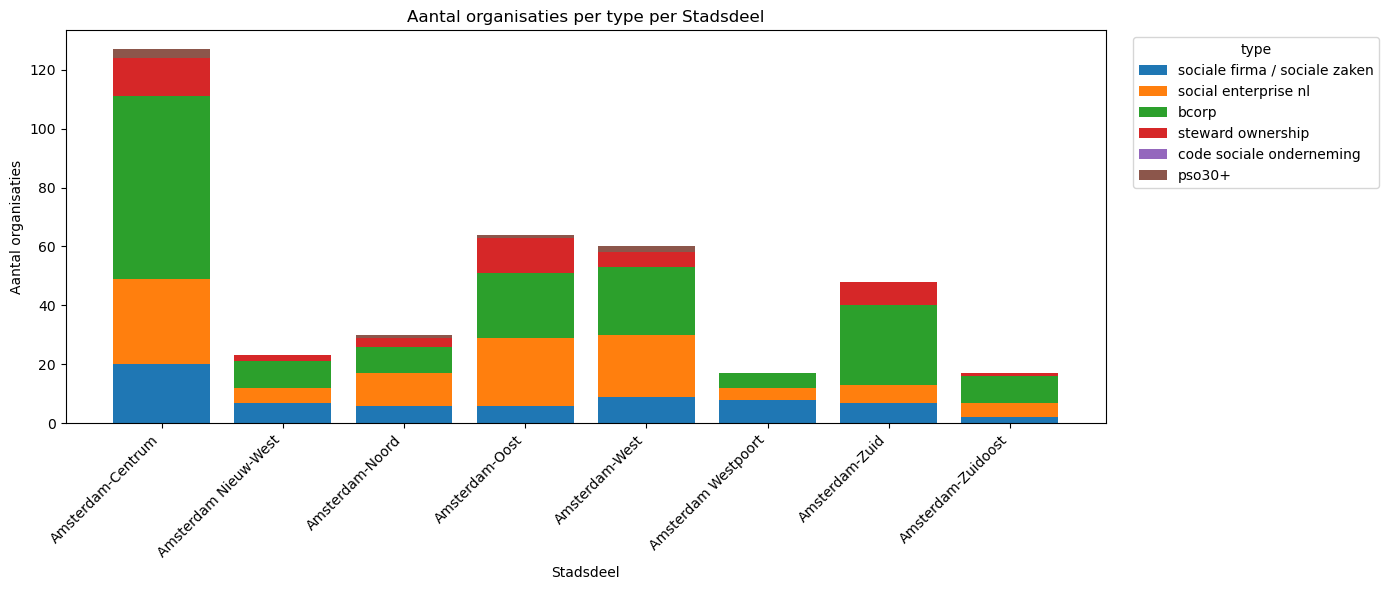

In [72]:

import matplotlib.pyplot as plt

# Optional: nicer names for the legend (edit to match your wording)
pretty = {
    "is_BCorp": "bcorp",
    "is_SocialeZaken": "sociale firma / sociale zaken",
    "is_SocialEnterpriseNL": "social enterprise nl",
    "is_CodeSocialeOndernemingen": "code sociale onderneming",
    "is_PSO": "pso30+",
    "is_StewardOwnership": "steward ownership",
    # add any extra label flags you may have created
}

# 1) stadsdeel order (match your bar order; include extras if present)
desired_order = [
    "Amsterdam-Centrum",
    "Amsterdam Nieuw-West",
    "Amsterdam-Noord",
    "Amsterdam-Oost",
    "Amsterdam-West",
    "Amsterdam Westpoort",
    "Amsterdam-Zuid",
    "Amsterdam-Zuidoost",
    "Buiten Amsterdam",
    "Weesp",
]

# if there are other stadsdelen in your data, append them at the end
all_sd = [s for s in master["stadsdeel"].dropna().unique().tolist() if str(s).strip() != ""]
remaining = [s for s in all_sd if s not in desired_order]
stadsdeel_order = [s for s in desired_order if s in all_sd] + sorted(remaining)

# 2) build counts: rows per stadsdeel per label
counts = (
    master.groupby("stadsdeel")[label_cols]
    .sum()
    .reindex(stadsdeel_order)
    .fillna(0)
    .astype(int)
)

# 3) rename columns for plot (legend)
counts = counts.rename(columns=lambda c: pretty.get(c, c.replace("is_", "")))

# 4) plot stacked bar
fig, ax = plt.subplots(figsize=(14, 6))

bottom = None
x = counts.index.astype(str)

for col in counts.columns:
    if bottom is None:
        ax.bar(x, counts[col].values, label=col)
        bottom = counts[col].values
    else:
        ax.bar(x, counts[col].values, bottom=bottom, label=col)
        bottom = bottom + counts[col].values

ax.set_title("Aantal organisaties per type per Stadsdeel")
ax.set_xlabel("Stadsdeel")
ax.set_ylabel("Aantal organisaties")
plt.xticks(rotation=45, ha="right")
ax.legend(title="type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
